In [1]:
from utils import *
from probabilistic_models import *

## Loading Datasets

In [2]:
df_1 = pd.read_excel(r"D:\Study\Python\Projects\Paul Project\vendor1.xlsx")
df_2 = pd.read_excel(r"D:\Study\Python\Projects\Paul Project\vendor2.xlsx")

In [5]:
def df_processor(df):
    df_1 = df.sort_values(by="Temperature", ascending=True).reset_index(drop=True)
    df_dict = {temp: df_1[df_1["Temperature"] == temp].reset_index(drop=True) for temp in df_1["Temperature"].unique()}

    df_1['Inverse_Temp'] = 11604.53 / (df_1['Temperature'] + 273.16)  # Convert to Kelvin
    df_1['Ln_Mpa'] = np.log(df_1['Mpa'])  # Log transformation

    return df_1, df_dict

In [6]:
df_dict = {temp: data_lcf[data_lcf["Temperature"] == temp].reset_index(drop=True) for temp in data_lcf["Temperature"].unique()}
data_lcf['Inverse_Temp'] = 11604.53 / (data_lcf['Temperature'] + 273.16)
data_lcf['Ln_Strain'] = np.log(data_lcf['Strain amplitude'])

In [8]:
data = pd.concat([df_1, df_2], ignore_index=True)
df,df_dict = df_processor(data)

In [9]:
df.to_excel(r"D:\Study\Python\Projects\Paul Project\main_data.xlsx", index=False)

In [10]:
X_values = df['Inverse_Temp'].values
Y_values = df['Mpa'].values

## Plot Utils

In [11]:
def plot_different_cdf(model,cdf=[0.5,0.9,0.1,0.99,0.01]):
    temperature_values = np.linspace(10, 600, 100)
    fig, ax = plt.subplots(figsize=(8,6))

    ax.scatter(df_1["Temperature"], df_1["Mpa"], edgecolors='black', alpha=0.7, s=30, label=f"Vendor 1")
    ax.scatter(df_2["Temperature"], df_2["Mpa"], edgecolors='black', alpha=0.7, s=30, label=f"Vendor 2")

    for i in range(len(cdf)):
        ys_predicted_cdf = model.predict(cdf[i],temperature_values)
        ax.plot(temperature_values, ys_predicted_cdf, linestyle="-", linewidth=1, label=f"Predicted YS (CDF={cdf[i]})")


    ax.set_xlabel("Temperature (°C)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Yield Stress (YS)", fontsize=12, fontweight="bold")
    ax.set_title("Yield Stress vs. Temperature Comparison", fontsize=14, fontweight="bold")
    ax.legend()
    fig.show()

In [12]:
def line_fit_plot(model):
    plt.figure(figsize=(10, 6))

    for temp in df_dict.keys():
        data = df_dict[temp]["Mpa"].values
        data = np.sort(data)

        try:
            sigma_values, ln_sigma_values,sigma_fit_log, y_fit = model.transform(data)
        except:
            sigma_values, ln_sigma_values,sigma_fit_log, y_fit = model.transform(data, temp)

        plt.scatter(sigma_values, ln_sigma_values, label=f"Temp {temp}")
        plt.plot(sigma_fit_log, y_fit, linestyle='-')

    plt.title(f" {model.name} Probability Plot with Fitted Line", fontsize=14, fontweight="bold")
    plt.xlabel("ln(Data)", fontsize=12)
    plt.ylabel("Standard Normal Quantile", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

## Weibull Model

In [22]:
class WeibullModel(ProbModel):
    def __init__(self,X_values:np.ndarray, Y_values:np.ndarray,X_values2:np.ndarray=np.array([]), power_law:bool=False)->None:
        """Intializes Weibull Probabilistic Model

        Args:
            X_values (np.ndarray): Temperature Values
            Y_values (np.ndarray): Sigma Values
            power_law (bool, optional): Whether to use power law or not. Defaults to False, which means that we will use Arrhenius equation instead of power law. 
        """
        self.X_values = X_values
        self.X_values2 = X_values2
        self.Y_values = Y_values
        self.name = "Weibull Model"
        self.tab_name = "Weibull"
        if power_law:
            self.name = "Weibull Model With Power Law"
            self.tab_name = "Weibull (Power)"

        # Figure out the parameters
        self.two_var = False
        if len(X_values2):
            # self.init_params = [2.0,-1, np.log(np.mean(self.Y_values)), -3.0]
            self.bounds = [(1e-6, 20), (-20, 20),(-20, 20), (-20, 20)]
            self.name = "Weibull Model With Two variables"
            self.two_var = True

            self.shape, self.intercept, self.slope, self.v = self.minimize(self.bounds, args=(self.X_values, self.Y_values, self.X_values2))
        else:
            # init_params = [2.0, np.log(np.mean(self.Y_values)), 0.0]
            bounds = [(1e-6, 30), (-10, 10), (-10, 10)]

            self.power_law = power_law
            self.shape, self.intercept, self.slope = self.minimize( bounds, args=(self.X_values, self.Y_values))

    def log_likelihood(self,params:list, temp:np.ndarray, sigma_values:np.ndarray, strain:np.ndarray=np.array([])):
        """Log likelihood 

        Args:
            params (list): parameters that are to be determined
            temp (np.ndarray)
            sigma_values (np.ndarray)
            strain(np.ndarray)

        Returns:
            Gives a negative sum of log likelihood for given data
        """
        shape = params[0]
        u = params[1]
        w = params[2]

        if shape <= 0:
            return np.inf
        
        if self.two_var:
            v = params[3]
            scale = np.exp(u + w * temp + v * strain)
        else:
            scale = np.exp(u + w * temp)

        return -np.sum(stats.weibull_min.logpdf(sigma_values, c=shape, scale=scale))

    def predict(self,cdf:float, temperature_values:np.ndarray)->np.ndarray:
        """To predict sigma values 

        Args:
            cdf (float)
            temperature_values (np.ndarray)

        Returns:
            Predicted sigma values according to the trained model
        """
        if self.power_law:
            return np.exp(
                (self.intercept + (self.slope * np.log(temperature_values))) +
                ((1 / self.shape) * np.log(np.log(1 / (1 - cdf))))
            )
        
        elif self.two_var:
            return np.exp(
            (self.intercept + (self.slope * 11604.53 / (temperature_values + 273.16)) + self.v * np.log(strain_values)) +
            ((1 / self.shape) * np.log(np.log(1 / (1 - cdf))))
        ) / 1000000

        return np.exp(
            (self.intercept + (self.slope * 11604.53 / (temperature_values + 273.16))) +
            ((1 / self.shape) * np.log(np.log(1 / (1 - cdf))))
        )
    
    @staticmethod
    def estimate_params(data:np.ndarray, **kwargs):
        shape, loc, scale = stats.weibull_min.fit(data, floc=0, **kwargs)
        return shape, scale
    
    def transform(self, data:np.ndarray):
        n = len(data)
        cdf_values = np.array([median_rank(n, i + 1) for i in range(n)])

        # Apply Weibull probability plot transformation
        sigma_values = np.log(data)  # X-axis: ln(data)
        wb_sigma_values = np.log(-np.log(1 - cdf_values))  # Y-axis: ln(-ln(1 - p))

        shape, scale = self.estimate_params(data, f0=self.shape)

        # Generate fitted Weibull line
        sigma_line = np.linspace(min(data), max(data), 100)
        pred_sigma_line = np.log(-np.log(1 - stats.weibull_min.cdf(sigma_line, shape, scale=scale)))
        
        self.transform_y_label = "ln(-ln(1 - p))"  # name to be displayed in the y-axis of the graph

        return sigma_values, wb_sigma_values, np.log(sigma_line), pred_sigma_line

In [23]:
weibull = WeibullModel(X_values, Y_values)

print(f"Shape: {weibull.shape:.4f}") 
print(f"Intercept (k): {weibull.intercept:.4f}")
print(f"Slope (m): {weibull.slope:.4f}")

Shape: 25.8125
Intercept (k): 5.8976
Slope (m): 0.0233


c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


C:\Users\mohit\AppData\Local\Temp\ipykernel_25556\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


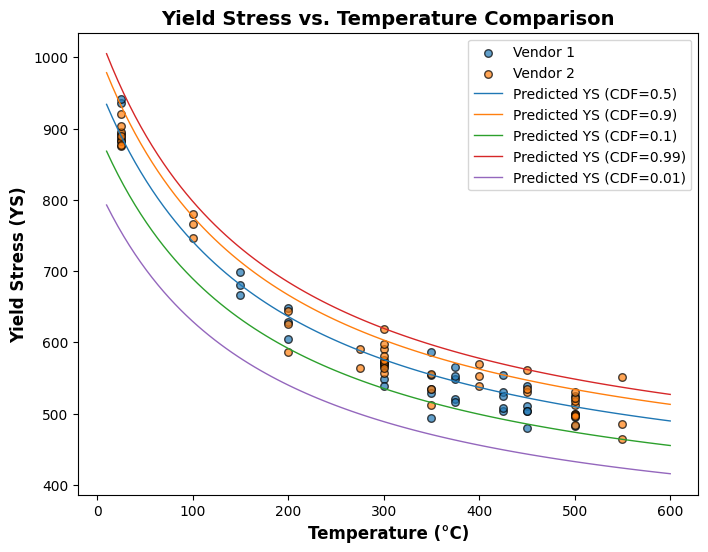

In [24]:
plot_different_cdf(weibull)

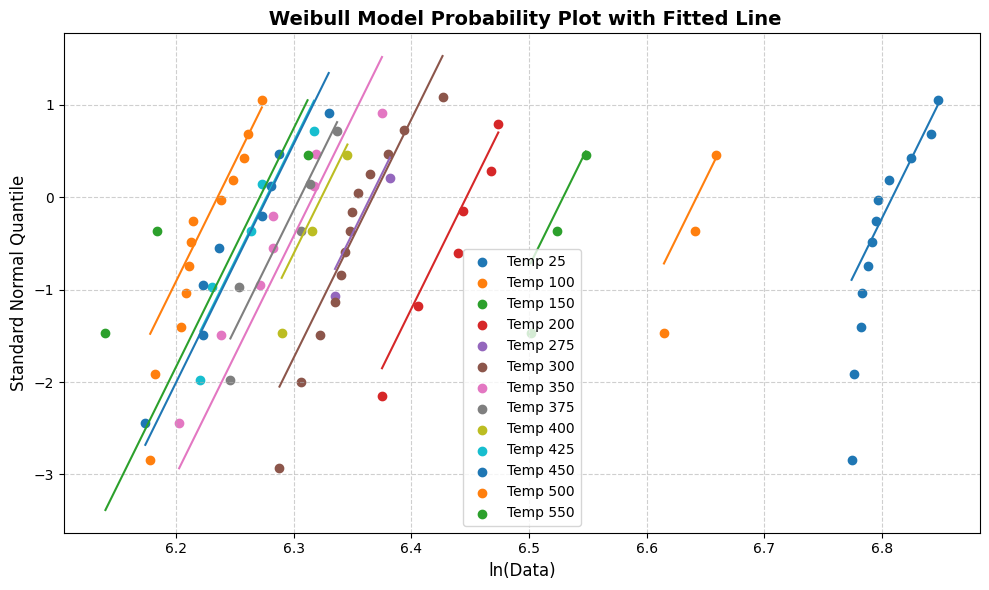

In [25]:
line_fit_plot(weibull)

## LogNormal Model

In [11]:
lognormal = LognormalModel(X_values, Y_values)

print(f"Sigma: {lognormal.sigma:.4f}") 
print(f"Intercept (k): {lognormal.k:.4f}")
print(f"Slope (m): {lognormal.m:.4f}")

Sigma: 0.0386
Intercept (k): 5.8598
Slope (m): 0.0242


C:\Users\mohit\AppData\Local\Temp\ipykernel_18124\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


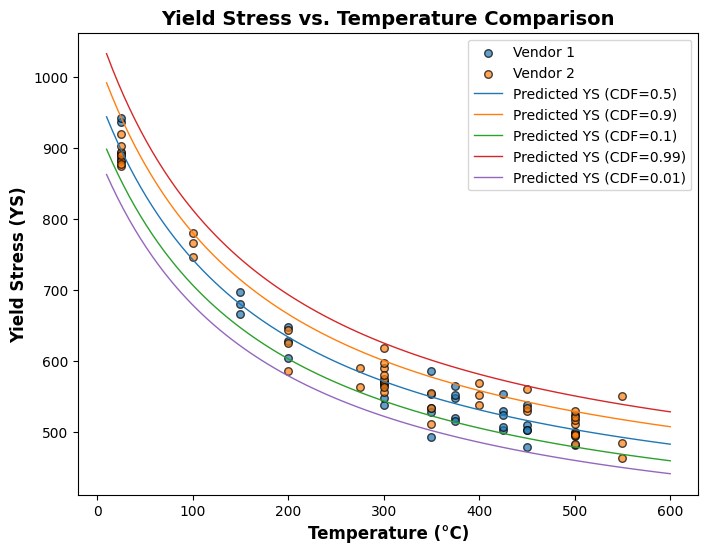

In [12]:
plot_different_cdf(lognormal)

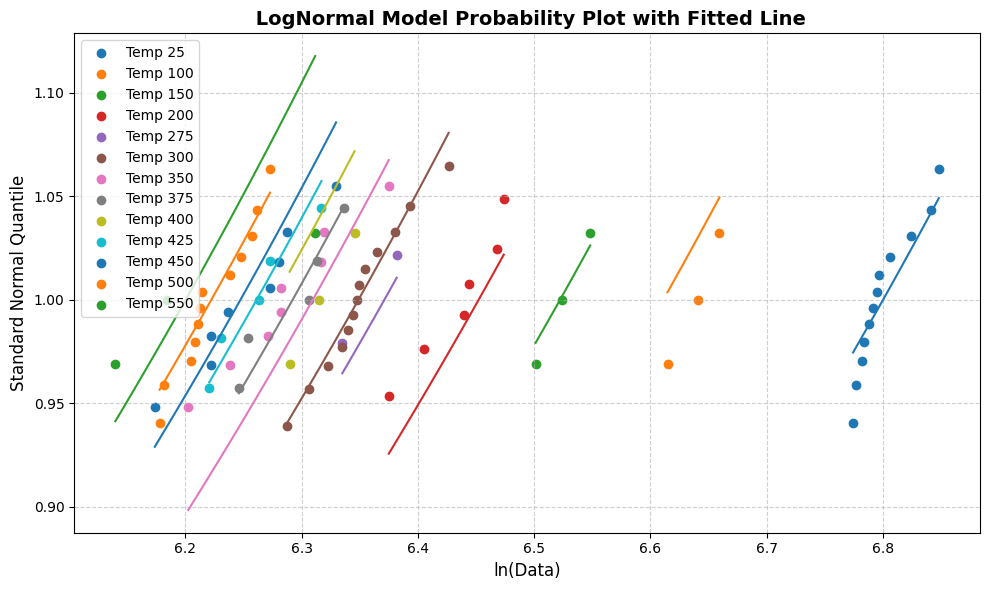

In [13]:
line_fit_plot(lognormal)

## Normal Model:

In [38]:
normal = NormalModel(X_values, Y_values)

print(f"Sigma: {normal.sigma:.4f}") 
print(f"Intercept (k): {normal.intercept:.4f}")
print(f"Slope (m): {normal.slope:.4f}")

Sigma: 24.8564
Intercept (k): 246.9873
Slope (m): 16.4713


C:\Users\mohit\AppData\Local\Temp\ipykernel_18124\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


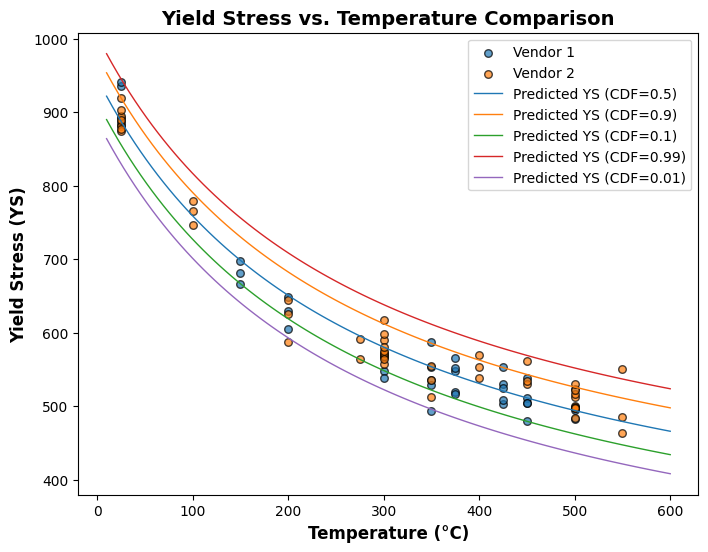

In [15]:
plot_different_cdf(normal)

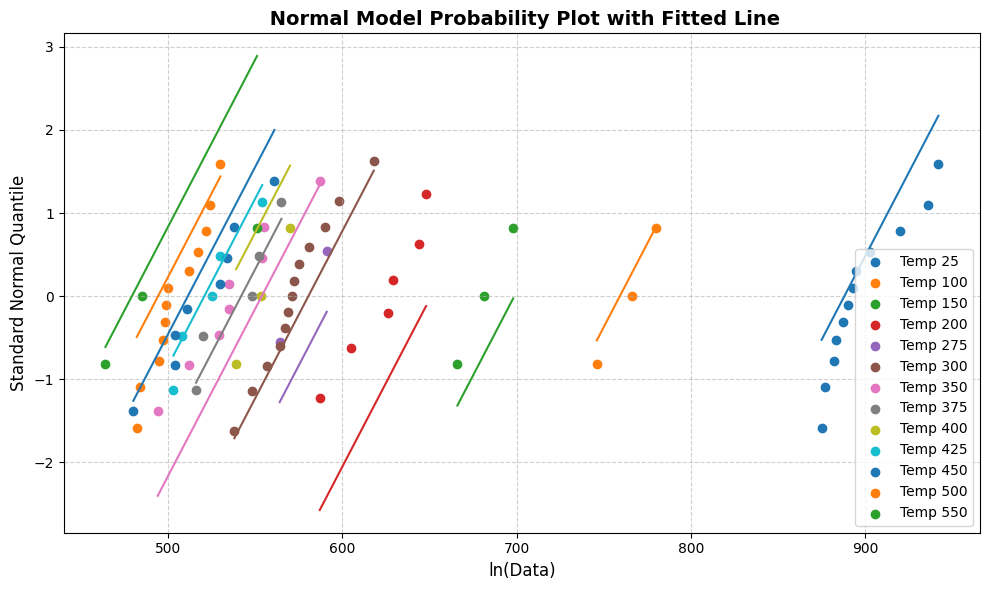

In [16]:
line_fit_plot(normal)

## Weibull (3-Parameters):

In [17]:
wb3 = WeibullModel3(X_values, Y_values)

print(f"Shape: {wb3.shape:.4f}") 
print(f"Delta: {wb3.delta:.4f}") 
print(f"Intercept (k): {wb3.intercept:.4f}")
print(f"Slope (m): {wb3.slope:.4f}")

Shape: 23.4686
Delta: 53.4825
Intercept (k): 5.7600
Slope (m): 0.0253


C:\Users\mohit\AppData\Local\Temp\ipykernel_18124\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


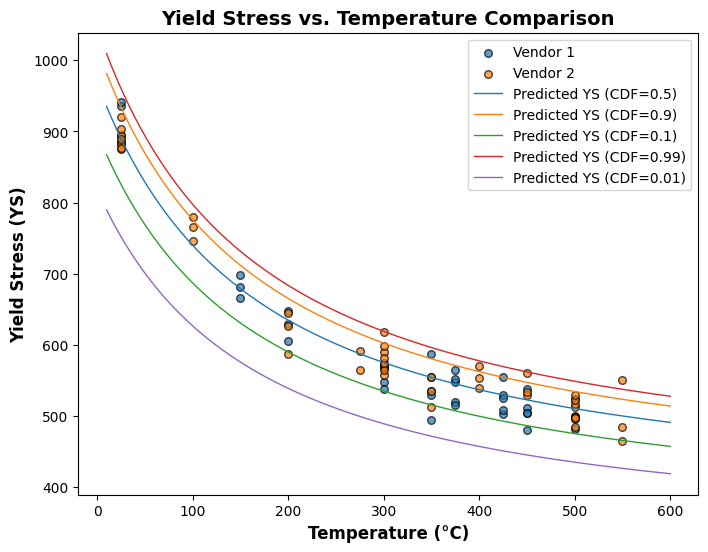

In [18]:
plot_different_cdf(wb3)

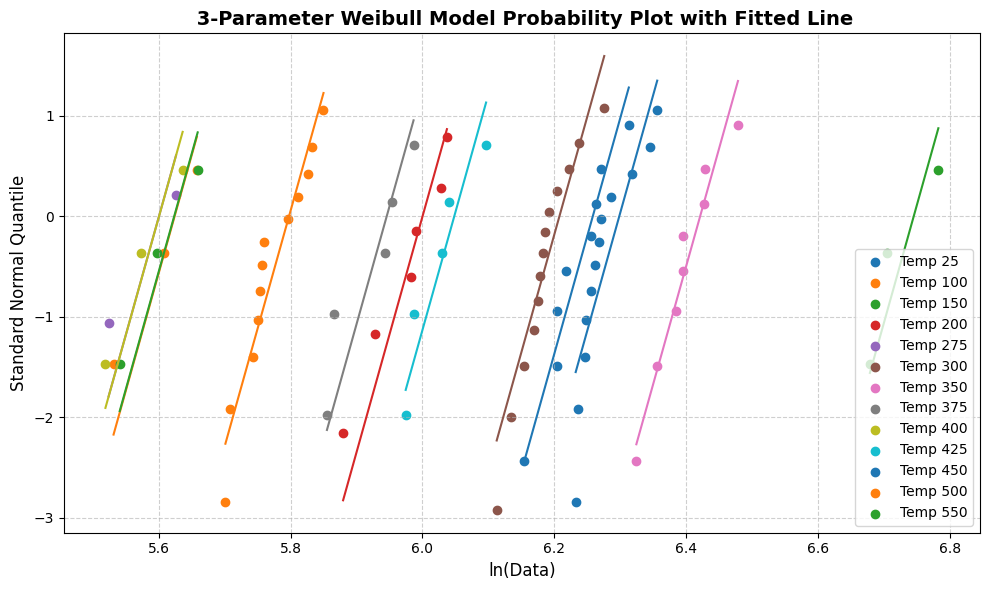

In [19]:
line_fit_plot(wb3)

## LogNormal3

In [20]:
lnm = LognormalModel3(X_values,Y_values)

print(f"Intercept (k): {lnm.k:.4f}")
print(f"Slope (m): {lnm.m:.4f}")
print(f"sigma: {lnm.sigma:.4f}")
print(f"gamma: {lnm.gamma:.4f}")

Intercept (k): 5.8574
Slope (m): 0.0242
sigma: 0.0387
gamma: 0.9896


C:\Users\mohit\AppData\Local\Temp\ipykernel_25556\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


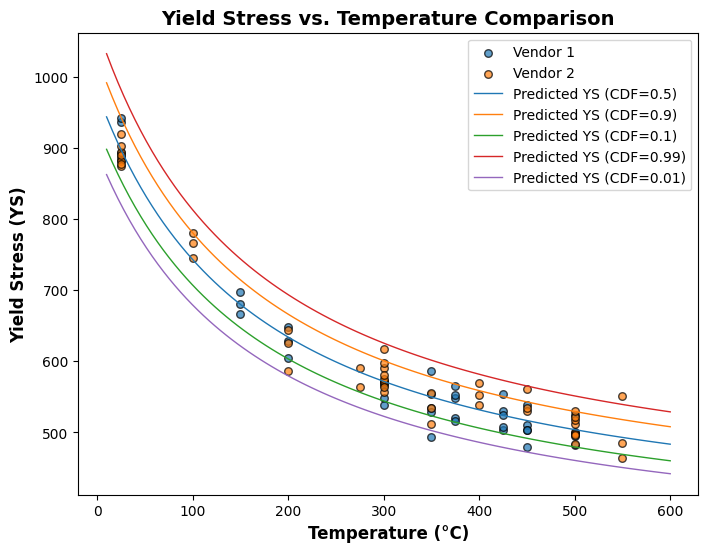

In [45]:
plot_different_cdf(lnm)

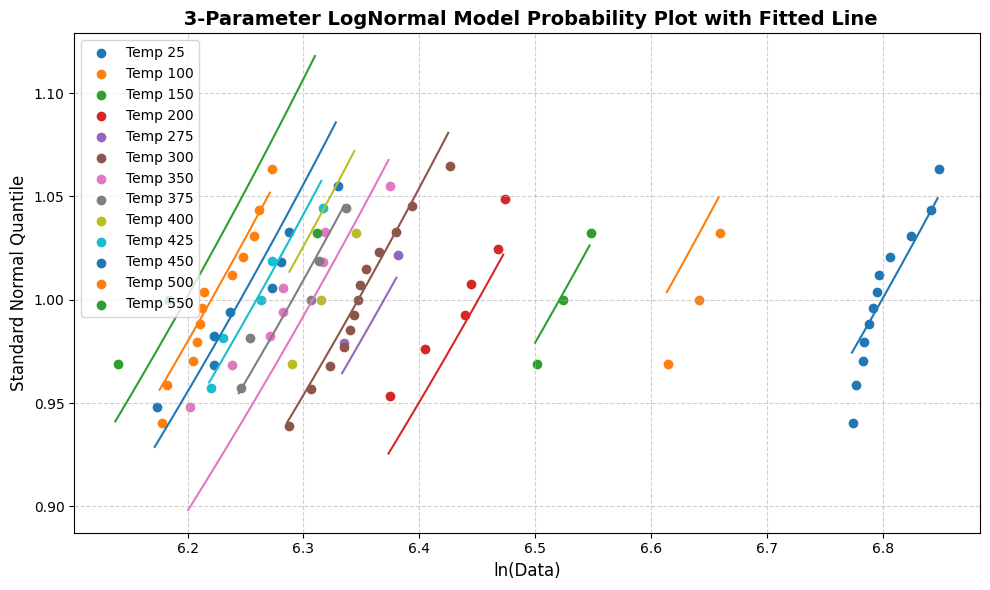

In [46]:
line_fit_plot(lnm)

## Gumbell Model:

In [56]:
gb = Gumbell(X_values, Y_values)

print(f"Intercept (u): {gb.intercept:.4f}")
print(f"Slope (w): {gb.slope:.4f}")
print(f"Gumbel Scale (sigma): {gb.scale:.4f}")

Intercept (u): 233.0584
Slope (w): 16.5455
Gumbel Scale (sigma): 24.5750


C:\Users\mohit\AppData\Local\Temp\ipykernel_25556\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


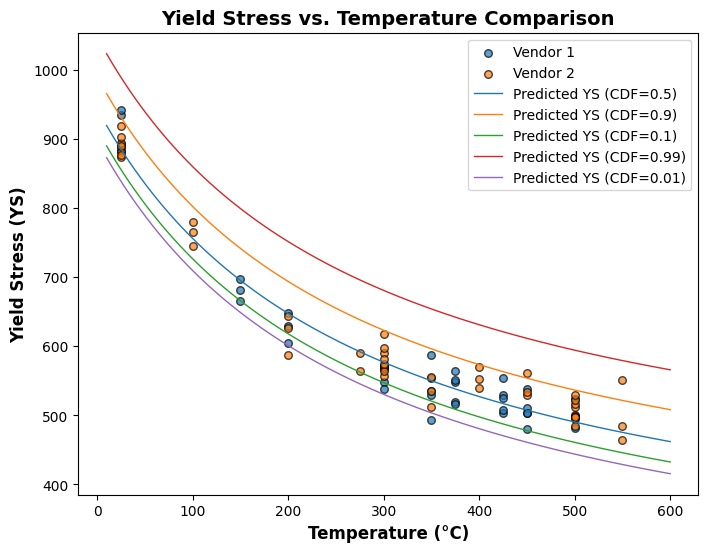

In [52]:
plot_different_cdf(gb)

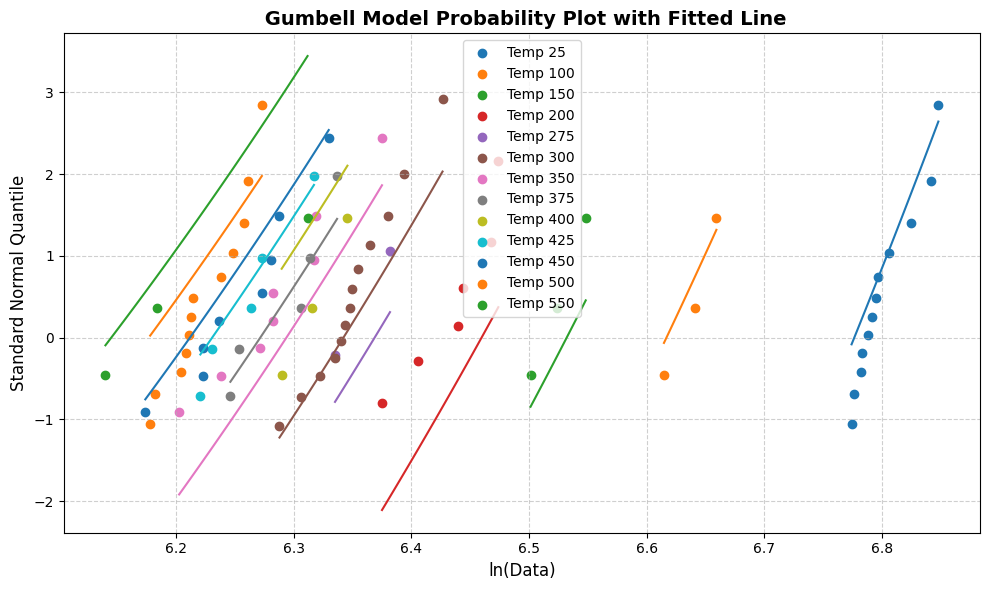

In [57]:
line_fit_plot(gb)

## Exponential:

In [72]:
exp = Exponential(X_values, Y_values)
print(f"Intercept (u): {exp.intercept:.4f}")
print(f"Slope (w): {exp.slope:.4f}")

Intercept (u): 5.8613
Slope (w): 0.0241


C:\Users\mohit\AppData\Local\Temp\ipykernel_25556\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


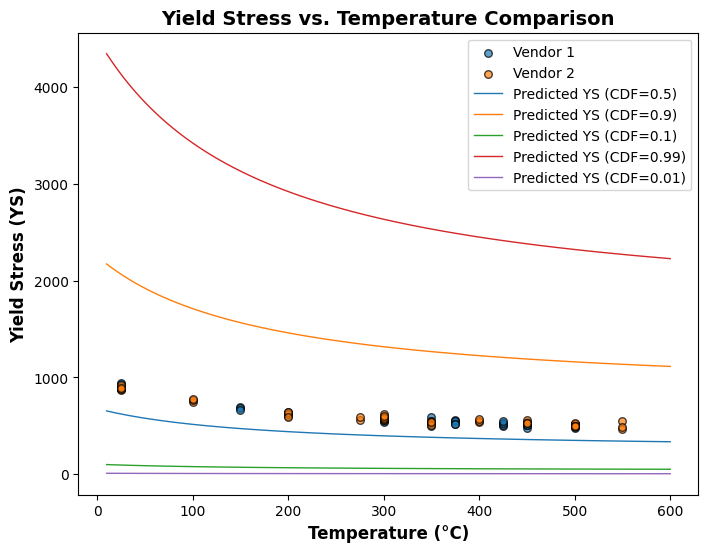

In [73]:
plot_different_cdf(exp)

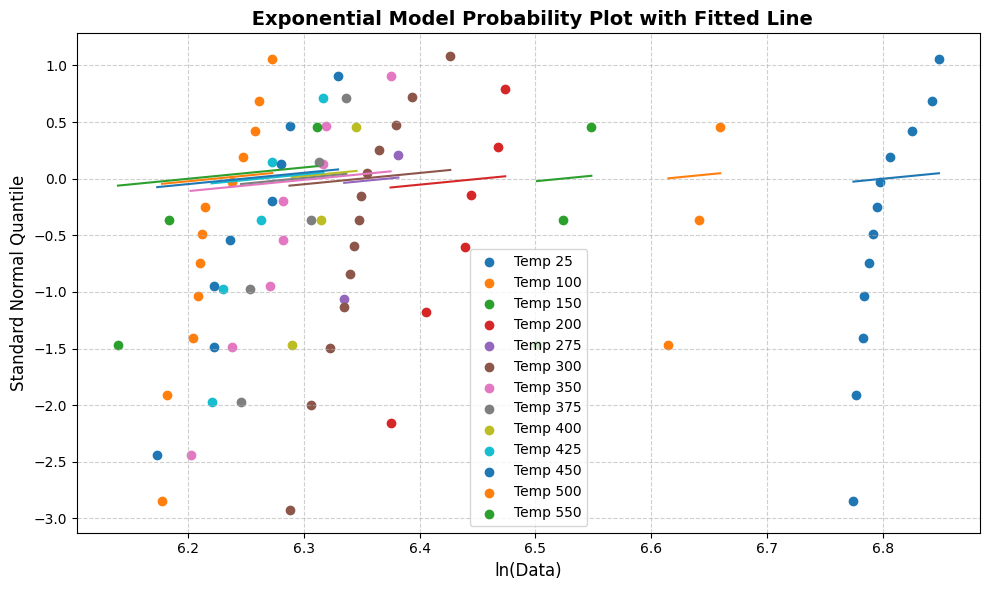

In [74]:
line_fit_plot(exp)

## Gamma

In [78]:
gm = Gamma(X_values, Y_values)
print(f"[Gamma Fit] Shape: {gm.shape:.4f}") 
print(f"Intercept (u): {gm.intercept:.4f}")
print(f"Slope (w): {gm.slope:.4f}")

c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[Gamma Fit] Shape: 433.9026
Intercept (u): -0.2116
Slope (w): 0.0241


C:\Users\mohit\AppData\Local\Temp\ipykernel_25556\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


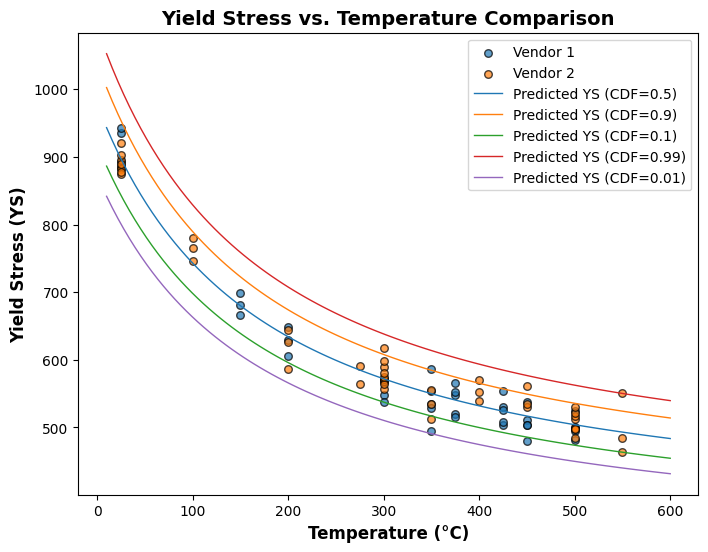

In [79]:
plot_different_cdf(gm)

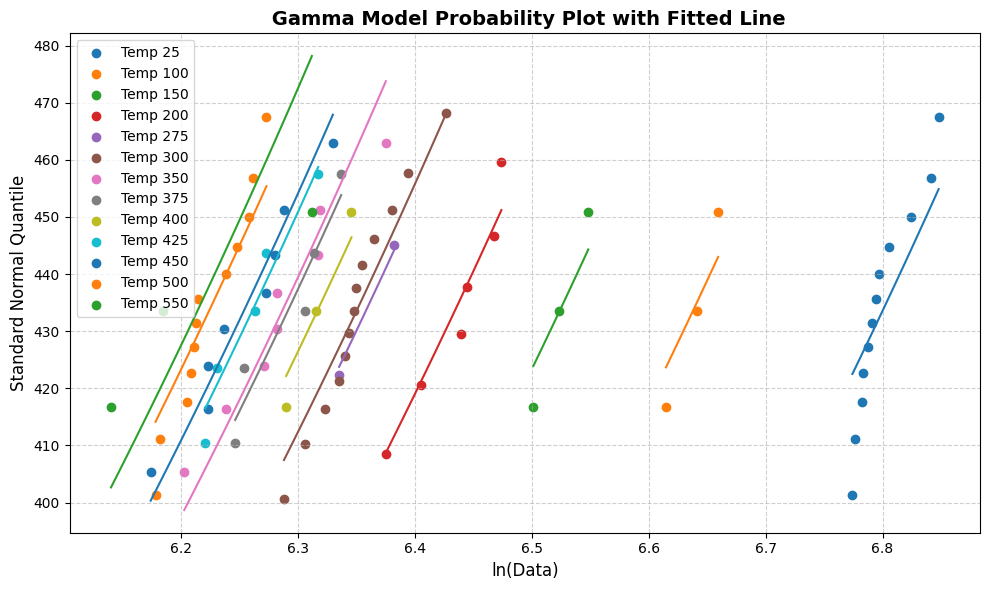

In [80]:
line_fit_plot(gm)

## Weibull (Power Law)

In [81]:
wb = WeibullModel(np.log(df['Temperature'].values), Y_values, power_law=True)

print(f"Shape: {gm.shape:.4f}") 
print(f"Intercept (u): {gm.intercept:.4f}")
print(f"Slope (w): {gm.slope:.4f}")

Shape: 433.9026
Intercept (u): -0.2116
Slope (w): 0.0241


c:\Users\mohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_continuous_distns.py:2584: RuntimeWarning: overflow encountered in power
  return np.log(c) + sc.xlogy(c - 1, x) - pow(x, c)


C:\Users\mohit\AppData\Local\Temp\ipykernel_25556\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


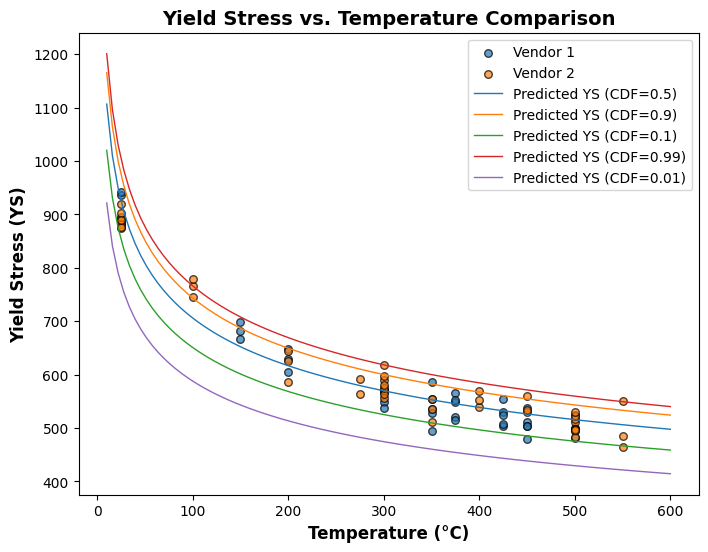

In [82]:
plot_different_cdf(wb)

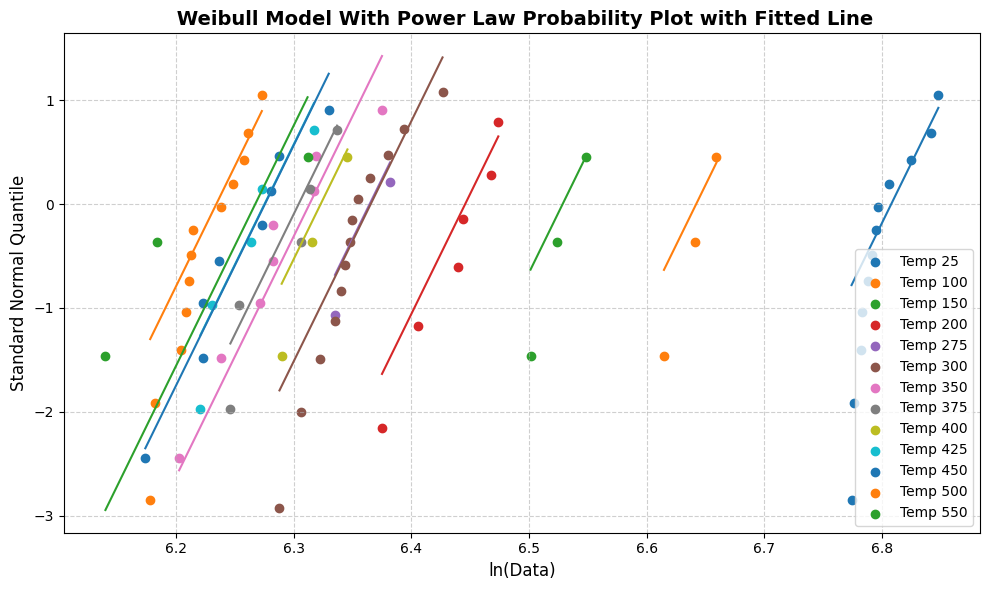

In [83]:
line_fit_plot(wb)

## Lognormal with power law

In [37]:
lm = LognormalModel(np.log(df['Temperature'].values), Y_values, power_law=True)

print(f"Sigma: {lm.sigma:.4f}") 
print(f"Intercept (k): {lm.k:.4f}")
print(f"Slope (m): {lm.m:.4f}")

Sigma: 0.0439
Intercept (k): 7.4442
Slope (m): -0.1938


C:\Users\mohit\AppData\Local\Temp\ipykernel_18124\2357539701.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


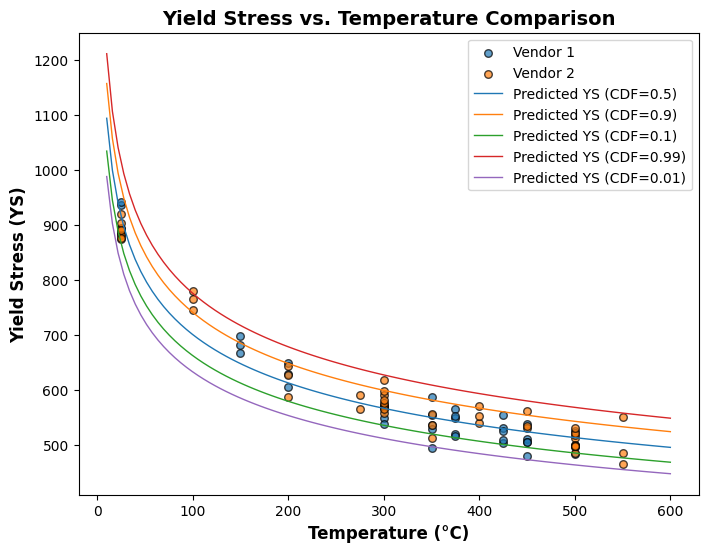

In [38]:
plot_different_cdf(lm)

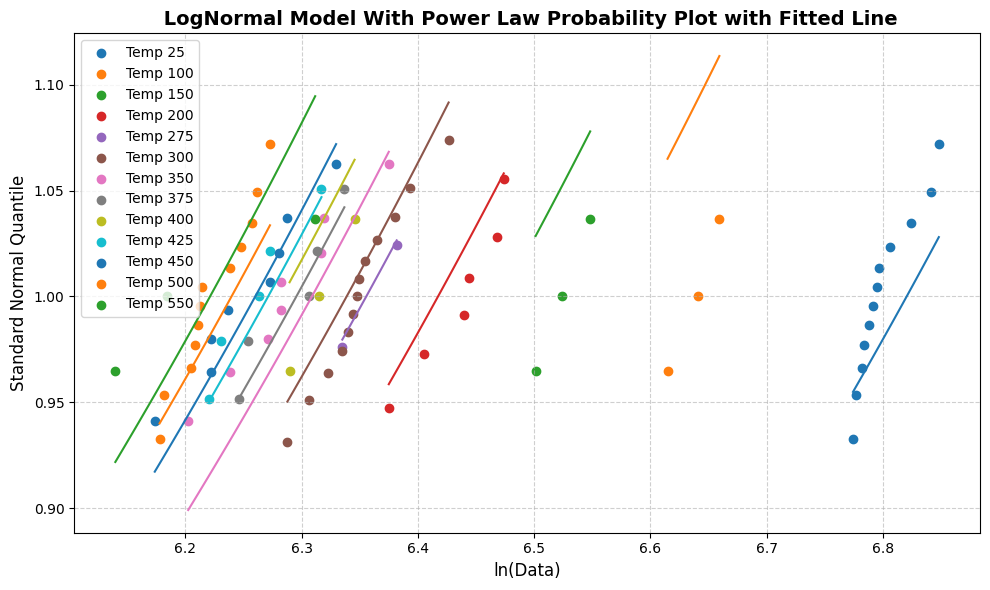

In [39]:
line_fit_plot(lm)